In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet
#from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import ParameterGrid
#from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import plot_cross_validation_metric, plot, plot_components,add_changepoints_to_plot

In [3]:
dataset = pd.read_csv("data.csv")

In [4]:
# change data type of ds column to pd.datatime as require of model Prophet
dataset['ds'] = pd.to_datetime(dataset['ds'], format='%d/%m/%Y')

# Splitting the data into train and test sets
train = dataset.iloc[:-4]  # Using all except the last 4 months for training
test = dataset.iloc[-4:]  # Using the last 4 months for testing

In [5]:
# using simple MAPE to find the best hyperparameter
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [6]:
model = Prophet()

# fit dataset
model.fit(train)

# create future want to predict
future = model.make_future_dataframe(periods=12, freq='MS') # predict next 12 months

# run forecast
forecast = model.predict(future)

21:41:09 - cmdstanpy - INFO - Chain [1] start processing
21:41:09 - cmdstanpy - INFO - Chain [1] done processing


In [7]:
# calcualte MAPE

MAPE = mean_absolute_percentage_error(test['y'],abs(forecast['yhat'][35:39]))
print(MAPE)

16.831647485565078


<Figure size 1000x600 with 0 Axes>

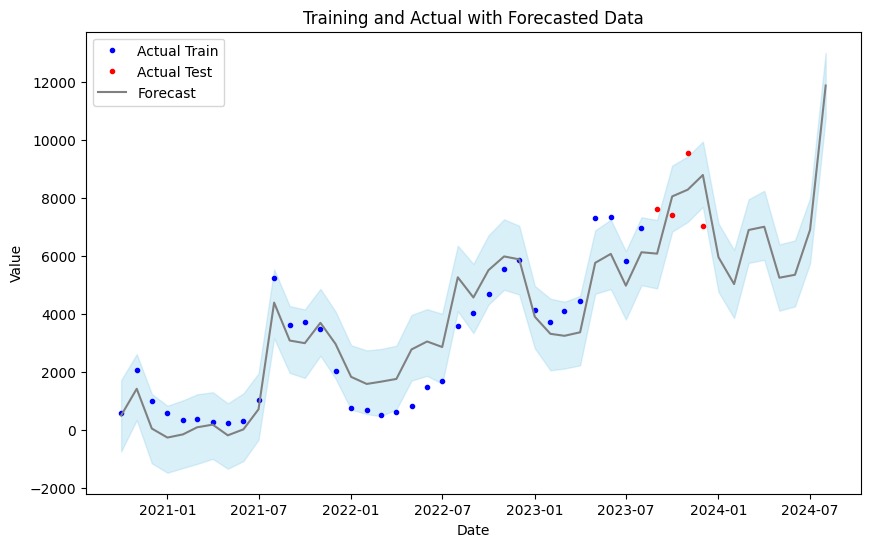

In [8]:
# show results
fig_1 = plt.figure(figsize=(10, 6))
plt.figure(figsize=(10, 6))
plt.plot(train["ds"], train["y"], '.', label='Actual Train', color = 'blue')
plt.plot(test["ds"], test["y"], '.', label='Actual Test', color = 'red')
plt.plot(forecast['ds'], forecast['yhat'], label='Forecast', color='grey')
plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='skyblue', alpha=0.3)
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Training and Actual with Forecasted Data')
plt.legend()
plt.show()

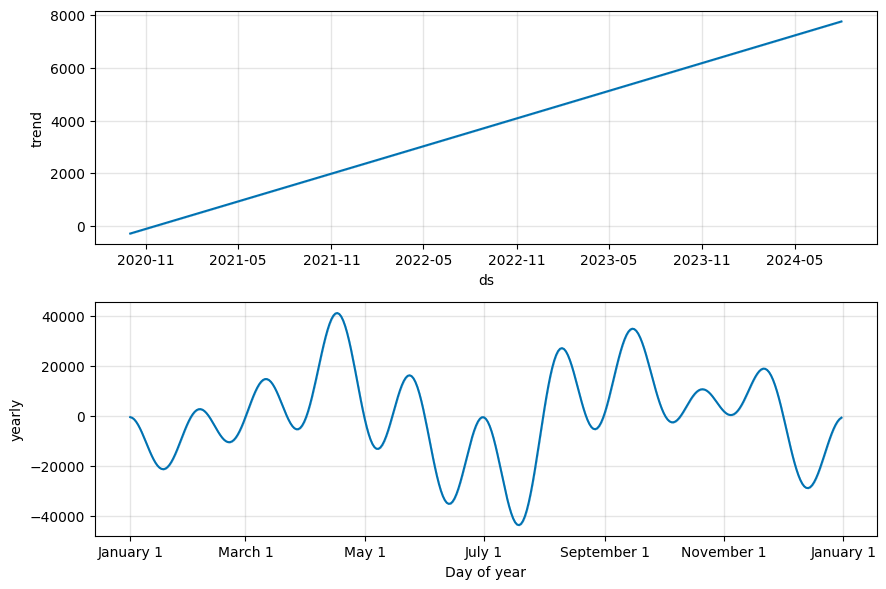

In [9]:
fig_2 = model.plot_components(forecast, plot_cap=20)

### Parameters that can be tuned

**changepoint_prior_scale**: This is probably the most impactful parameter. It determines the flexibility of the trend, and in particular how much the trend changes at the trend changepoints. As described in this documentation, if it is too small, the trend will be underfit and variance that should have been modeled with trend changes will instead end up being handled with the noise term. If it is too large, the trend will overfit and in the most extreme case you can end up with the trend capturing yearly seasonality. The default of 0.05 works for many time series, but this could be tuned; a range of [0.001, 0.5] would likely be about right. Parameters like this (regularization penalties; this is effectively a lasso penalty) are often tuned on a log scale.

**seasonality_prior_scale**: This parameter controls the flexibility of the seasonality. Similarly, a large value allows the seasonality to fit large fluctuations, a small value shrinks the magnitude of the seasonality. The default is 10., which applies basically no regularization. That is because we very rarely see overfitting here (there’s inherent regularization with the fact that it is being modeled with a truncated Fourier series, so it’s essentially low-pass filtered). A reasonable range for tuning it would probably be [0.01, 10]; when set to 0.01 you should find that the magnitude of seasonality is forced to be very small. This likely also makes sense on a log scale, since it is effectively an L2 penalty like in ridge regression.

**holidays_prior_scale**: This controls flexibility to fit holiday effects. Similar to seasonality_prior_scale, it defaults to 10.0 which applies basically no regularization, since we usually have multiple observations of holidays and can do a good job of estimating their effects. This could also be tuned on a range of [0.01, 10] as with seasonality_prior_scale.

**seasonality_mode**: Options are ['additive', 'multiplicative']. Default is 'additive', but many business time series will have multiplicative seasonality. This is best identified just from looking at the time series and seeing if the magnitude of seasonal fluctuations grows with the magnitude of the time series (see the documentation here on multiplicative seasonality), but when that isn’t possible, it could be tuned.

In [10]:
# input hyperparameter want to try
params_grid = {'seasonality_mode':('multiplicative','additive'),
            'changepoint_prior_scale':[0.001, 0.002, 0.003, 0.004, 0.005,
                                        0.01, 0.02, 0.03, 0.04, 0.05,
                                        0.1,0.2, 0.3, 0.4, 0.5],
            'seasonality_prior_scale':[0.01, 0.02, 0.03, 0.04, 0.05,
                                        0.1,0.2, 0.3, 0.4, 0.5,
                                        1.0, 2.0, 3.0, 4.0, 5.0, 10.0]}

# make parameters grid to test
grid = ParameterGrid(params_grid)

# trial numbers
cnt = 0
for p in grid:
    cnt = cnt+1
print('Total Possible Models',cnt)

Total Possible Models 480


In [11]:
# create initial DataFrame
model_parameters = pd.DataFrame(columns = ['MAPE','Parameters'])

#trial count
_try = 0

# try hyperparameters
for p in grid:
    train_forecast = pd.DataFrame()
    train_model =Prophet(changepoint_prior_scale = p['changepoint_prior_scale'],
                        seasonality_prior_scale = p['seasonality_prior_scale'],
                        seasonality_mode = p['seasonality_mode'])
    train_model.fit(train)
    train_forecast = train_model.make_future_dataframe(periods=12, freq='MS')
    train_forecast = train_model.predict(train_forecast)
    train_forecast = train_forecast[['ds','yhat']]
    train_forecast = train_forecast[35:39]
    train_test = test
    MAPE = mean_absolute_percentage_error(train_test['y'],abs(train_forecast['yhat']))
    _try +=1
    print('--------------------------------------------------------------------------------------------------')
    print('try', _try, '-- Mean Absolute Percentage Error(MAPE)------------------------------------',MAPE)
    try_parameter = pd.DataFrame({'MAPE':MAPE,'Parameters':[p]})
    model_parameters = pd.concat([model_parameters,try_parameter],ignore_index=True)

21:41:10 - cmdstanpy - INFO - Chain [1] start processing
21:41:10 - cmdstanpy - INFO - Chain [1] done processing
21:41:10 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 1 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 19.79639036347715


21:41:11 - cmdstanpy - INFO - Chain [1] done processing
21:41:11 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 2 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 20.665868753175527


21:41:11 - cmdstanpy - INFO - Chain [1] done processing
21:41:11 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 3 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 19.887540945936394


21:41:11 - cmdstanpy - INFO - Chain [1] done processing
21:41:11 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 4 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 18.7895064224501


21:41:12 - cmdstanpy - INFO - Chain [1] done processing
21:41:12 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 5 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 17.500945787152993


21:41:12 - cmdstanpy - INFO - Chain [1] done processing
21:41:12 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 6 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 12.13215018868633


21:41:13 - cmdstanpy - INFO - Chain [1] done processing
21:41:13 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 7 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 9.965839462280146


21:41:14 - cmdstanpy - INFO - Chain [1] done processing
21:41:14 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 8 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 9.02907966756891


21:41:15 - cmdstanpy - INFO - Chain [1] done processing
21:41:16 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 9 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 9.63499740960311


21:41:16 - cmdstanpy - INFO - Chain [1] done processing
21:41:16 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 10 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 9.399251458423633


21:41:17 - cmdstanpy - INFO - Chain [1] done processing
21:41:17 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 11 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 9.799875347519308


21:41:17 - cmdstanpy - INFO - Chain [1] done processing
21:41:17 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 12 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 10.703887785143037


21:41:17 - cmdstanpy - INFO - Chain [1] done processing
21:41:18 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 13 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 11.630346396033959


21:41:18 - cmdstanpy - INFO - Chain [1] done processing
21:41:18 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 14 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 14.91087237913938


21:41:19 - cmdstanpy - INFO - Chain [1] done processing
21:41:20 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 15 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 14.950633005279872


21:41:20 - cmdstanpy - INFO - Chain [1] done processing
21:41:20 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 16 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 22.82051997976256


21:41:20 - cmdstanpy - INFO - Chain [1] done processing
21:41:20 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 17 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 20.697860058962192


21:41:20 - cmdstanpy - INFO - Chain [1] done processing
21:41:21 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 18 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 18.85597192545259


21:41:21 - cmdstanpy - INFO - Chain [1] done processing
21:41:21 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 19 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 15.80162075807056


21:41:21 - cmdstanpy - INFO - Chain [1] done processing
21:41:21 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 20 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 11.639694514261995


21:41:22 - cmdstanpy - INFO - Chain [1] done processing
21:41:22 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 21 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 11.814635360335918


21:41:23 - cmdstanpy - INFO - Chain [1] done processing
21:41:23 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 22 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 7.409226158575125


21:41:23 - cmdstanpy - INFO - Chain [1] done processing
21:41:24 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 23 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 7.563794420216026


21:41:24 - cmdstanpy - INFO - Chain [1] done processing
21:41:24 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 24 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 7.594446736818111


21:41:24 - cmdstanpy - INFO - Chain [1] done processing
21:41:24 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 25 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 7.869385428390629


21:41:24 - cmdstanpy - INFO - Chain [1] done processing
21:41:25 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 26 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 7.54216165227364


21:41:25 - cmdstanpy - INFO - Chain [1] done processing
21:41:25 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 27 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 10.107731487215386


21:41:26 - cmdstanpy - INFO - Chain [1] done processing
21:41:26 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 28 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 14.979365188771695


21:41:26 - cmdstanpy - INFO - Chain [1] done processing
21:41:26 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 29 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 16.415612237042467


21:41:27 - cmdstanpy - INFO - Chain [1] done processing
21:41:27 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 30 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 15.763273535772765


21:41:27 - cmdstanpy - INFO - Chain [1] done processing
21:41:27 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 31 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 15.638196561083056


21:41:27 - cmdstanpy - INFO - Chain [1] done processing
21:41:27 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 32 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 16.788006111089565


21:41:27 - cmdstanpy - INFO - Chain [1] done processing
21:41:28 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 33 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 21.531737828718818


21:41:28 - cmdstanpy - INFO - Chain [1] done processing
21:41:28 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 34 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 21.39651325057959


21:41:28 - cmdstanpy - INFO - Chain [1] done processing
21:41:28 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 35 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 18.388586236977606


21:41:29 - cmdstanpy - INFO - Chain [1] done processing
21:41:29 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 36 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 18.741313194664073


21:41:29 - cmdstanpy - INFO - Chain [1] done processing
21:41:29 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 37 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 17.445027357696564


21:41:29 - cmdstanpy - INFO - Chain [1] done processing
21:41:30 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 38 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 12.309595829206167


21:41:30 - cmdstanpy - INFO - Chain [1] done processing
21:41:30 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 39 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 9.168450205034858


21:41:30 - cmdstanpy - INFO - Chain [1] done processing
21:41:30 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 40 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 8.724617633496127


21:41:31 - cmdstanpy - INFO - Chain [1] done processing
21:41:31 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 41 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 9.272437656065279


21:41:31 - cmdstanpy - INFO - Chain [1] done processing
21:41:31 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 42 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 8.884639371737034


21:41:32 - cmdstanpy - INFO - Chain [1] done processing
21:41:32 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 43 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 9.718312091984316


21:41:33 - cmdstanpy - INFO - Chain [1] done processing
21:41:33 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 44 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 10.637508890481378


21:41:33 - cmdstanpy - INFO - Chain [1] done processing
21:41:33 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 45 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 12.784001337428313


21:41:34 - cmdstanpy - INFO - Chain [1] done processing
21:41:34 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 46 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 14.558291358979805


21:41:34 - cmdstanpy - INFO - Chain [1] done processing
21:41:34 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 47 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 14.999146746750878


21:41:34 - cmdstanpy - INFO - Chain [1] done processing
21:41:34 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 48 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 22.967207900379435


21:41:34 - cmdstanpy - INFO - Chain [1] done processing
21:41:35 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 49 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 19.387721322212904


21:41:36 - cmdstanpy - INFO - Chain [1] done processing
21:41:36 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 50 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 18.81800977750876


21:41:36 - cmdstanpy - INFO - Chain [1] done processing
21:41:36 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 51 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 15.79963903756888


21:41:36 - cmdstanpy - INFO - Chain [1] done processing
21:41:36 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 52 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 13.384164188259751


21:41:37 - cmdstanpy - INFO - Chain [1] done processing
21:41:37 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 53 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 11.356942957065343


21:41:37 - cmdstanpy - INFO - Chain [1] done processing
21:41:37 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 54 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 7.808579144996236


21:41:37 - cmdstanpy - INFO - Chain [1] done processing
21:41:37 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 55 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 7.650723717352401


21:41:38 - cmdstanpy - INFO - Chain [1] done processing
21:41:38 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 56 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 7.596594865778339


21:41:38 - cmdstanpy - INFO - Chain [1] done processing
21:41:38 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 57 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 7.866191494663897


21:41:38 - cmdstanpy - INFO - Chain [1] done processing
21:41:39 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 58 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 7.573758394365636


21:41:39 - cmdstanpy - INFO - Chain [1] done processing
21:41:39 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 59 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 10.250542450492253


21:41:40 - cmdstanpy - INFO - Chain [1] done processing
21:41:40 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 60 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 13.878008789513425


21:41:40 - cmdstanpy - INFO - Chain [1] done processing
21:41:40 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 61 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 16.337636680624833


21:41:41 - cmdstanpy - INFO - Chain [1] done processing
21:41:41 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 62 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 15.844297053481139


21:41:41 - cmdstanpy - INFO - Chain [1] done processing
21:41:41 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 63 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 16.450036414998394


21:41:41 - cmdstanpy - INFO - Chain [1] done processing
21:41:41 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 64 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 16.793544960577332


21:41:42 - cmdstanpy - INFO - Chain [1] done processing
21:41:42 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 65 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 21.465581216365564


21:41:42 - cmdstanpy - INFO - Chain [1] done processing
21:41:42 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 66 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 21.273857426972278


21:41:42 - cmdstanpy - INFO - Chain [1] done processing
21:41:42 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 67 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 19.28379200530304


21:41:42 - cmdstanpy - INFO - Chain [1] done processing
21:41:43 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 68 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 18.596824428815694


21:41:43 - cmdstanpy - INFO - Chain [1] done processing
21:41:43 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 69 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 17.315294777010266


21:41:43 - cmdstanpy - INFO - Chain [1] done processing
21:41:43 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 70 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 12.28523459231746


21:41:43 - cmdstanpy - INFO - Chain [1] done processing
21:41:44 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 71 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 8.697584753882046


21:41:44 - cmdstanpy - INFO - Chain [1] done processing
21:41:44 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 72 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 8.621520456005618


21:41:44 - cmdstanpy - INFO - Chain [1] done processing
21:41:44 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 73 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 8.836471865199195


21:41:44 - cmdstanpy - INFO - Chain [1] done processing
21:41:44 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 74 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 9.02655486270946


21:41:45 - cmdstanpy - INFO - Chain [1] done processing
21:41:45 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 75 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 9.63068042127718


21:41:45 - cmdstanpy - INFO - Chain [1] done processing
21:41:45 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 76 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 10.490167856713375


21:41:45 - cmdstanpy - INFO - Chain [1] done processing
21:41:45 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 77 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 12.469841985904377


21:41:46 - cmdstanpy - INFO - Chain [1] done processing
21:41:46 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 78 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 14.003605339308345


21:41:46 - cmdstanpy - INFO - Chain [1] done processing
21:41:46 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 79 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 14.801530900669006


21:41:46 - cmdstanpy - INFO - Chain [1] done processing
21:41:46 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 80 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 22.95672803288507


21:41:46 - cmdstanpy - INFO - Chain [1] done processing
21:41:47 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 81 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 20.231552272670772


21:41:47 - cmdstanpy - INFO - Chain [1] done processing
21:41:47 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 82 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 18.783668245216905


21:41:47 - cmdstanpy - INFO - Chain [1] done processing
21:41:47 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 83 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 16.009113430067544


21:41:48 - cmdstanpy - INFO - Chain [1] done processing
21:41:48 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 84 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 13.350517513294838


21:41:48 - cmdstanpy - INFO - Chain [1] done processing
21:41:48 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 85 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 11.662835388974706


21:41:48 - cmdstanpy - INFO - Chain [1] done processing
21:41:48 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 86 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 8.403223523374914


21:41:48 - cmdstanpy - INFO - Chain [1] done processing
21:41:49 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 87 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 7.649926315358579


21:41:49 - cmdstanpy - INFO - Chain [1] done processing
21:41:49 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 88 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 7.6038517745365475


21:41:49 - cmdstanpy - INFO - Chain [1] done processing
21:41:49 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 89 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 7.841310996137032


21:41:49 - cmdstanpy - INFO - Chain [1] done processing
21:41:49 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 90 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 7.646719697997276


21:41:50 - cmdstanpy - INFO - Chain [1] done processing
21:41:50 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 91 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 10.26438360531887


21:41:50 - cmdstanpy - INFO - Chain [1] done processing
21:41:50 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 92 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 13.914478081468046


21:41:50 - cmdstanpy - INFO - Chain [1] done processing
21:41:51 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 93 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 15.566828753764895


21:41:51 - cmdstanpy - INFO - Chain [1] done processing
21:41:51 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 94 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 15.798351156145287


21:41:51 - cmdstanpy - INFO - Chain [1] done processing
21:41:51 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 95 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 16.499601160954935


21:41:51 - cmdstanpy - INFO - Chain [1] done processing
21:41:52 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 96 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 16.799100658161734


21:41:52 - cmdstanpy - INFO - Chain [1] done processing
21:41:52 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 97 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 21.445827592929252


21:41:52 - cmdstanpy - INFO - Chain [1] done processing
21:41:52 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 98 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 20.120231088824593


21:41:53 - cmdstanpy - INFO - Chain [1] done processing
21:41:53 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 99 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 19.307484292441988


21:41:53 - cmdstanpy - INFO - Chain [1] done processing
21:41:53 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 100 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 18.589988048001672


21:41:54 - cmdstanpy - INFO - Chain [1] done processing
21:41:54 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 101 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 17.304925585649002


21:41:54 - cmdstanpy - INFO - Chain [1] done processing
21:41:54 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 102 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 12.263666311378717


21:41:54 - cmdstanpy - INFO - Chain [1] done processing
21:41:54 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 103 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 8.791177437201034


21:41:55 - cmdstanpy - INFO - Chain [1] done processing
21:41:55 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 104 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 8.621144256730014


21:41:55 - cmdstanpy - INFO - Chain [1] done processing
21:41:55 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 105 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 8.622533287359714


21:41:55 - cmdstanpy - INFO - Chain [1] done processing
21:41:55 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 106 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 8.95240278157587


21:41:56 - cmdstanpy - INFO - Chain [1] done processing
21:41:56 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 107 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 9.673346371139866


21:41:56 - cmdstanpy - INFO - Chain [1] done processing
21:41:56 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 108 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 10.443010738489118


21:41:56 - cmdstanpy - INFO - Chain [1] done processing
21:41:57 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 109 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 12.503730694840149


21:41:57 - cmdstanpy - INFO - Chain [1] done processing
21:41:57 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 110 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 14.136086039235266


21:41:57 - cmdstanpy - INFO - Chain [1] done processing
21:41:57 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 111 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 15.061837661260565


21:41:57 - cmdstanpy - INFO - Chain [1] done processing
21:41:58 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 112 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 22.833484629293135


21:41:58 - cmdstanpy - INFO - Chain [1] done processing
21:41:58 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 113 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 20.255244685895455


21:41:58 - cmdstanpy - INFO - Chain [1] done processing
21:41:58 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 114 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 18.776659685259933


21:41:58 - cmdstanpy - INFO - Chain [1] done processing
21:41:59 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 115 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 16.00068952512571


21:41:59 - cmdstanpy - INFO - Chain [1] done processing
21:41:59 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 116 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 13.348976300983665


21:41:59 - cmdstanpy - INFO - Chain [1] done processing
21:41:59 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 117 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 11.655420508432757


21:42:00 - cmdstanpy - INFO - Chain [1] done processing
21:42:00 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 118 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 8.041577541957388


21:42:00 - cmdstanpy - INFO - Chain [1] done processing
21:42:00 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 119 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 7.653478852449708


21:42:00 - cmdstanpy - INFO - Chain [1] done processing
21:42:00 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 120 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 7.601956189642042


21:42:01 - cmdstanpy - INFO - Chain [1] done processing
21:42:01 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 121 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 7.811021199331254


21:42:01 - cmdstanpy - INFO - Chain [1] done processing
21:42:01 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 122 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 7.647776659236472


21:42:02 - cmdstanpy - INFO - Chain [1] done processing
21:42:02 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 123 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 10.402294105895923


21:42:02 - cmdstanpy - INFO - Chain [1] done processing
21:42:02 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 124 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 14.038745094253605


21:42:02 - cmdstanpy - INFO - Chain [1] done processing
21:42:02 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 125 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 15.573953335447682


21:42:03 - cmdstanpy - INFO - Chain [1] done processing
21:42:03 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 126 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 16.40585131847373


21:42:03 - cmdstanpy - INFO - Chain [1] done processing
21:42:03 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 127 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 16.61420497323352


21:42:03 - cmdstanpy - INFO - Chain [1] done processing
21:42:03 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 128 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 16.819264932561875


21:42:04 - cmdstanpy - INFO - Chain [1] done processing
21:42:04 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 129 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 19.578415221628816


21:42:04 - cmdstanpy - INFO - Chain [1] done processing
21:42:04 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 130 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 19.136664461137073


21:42:04 - cmdstanpy - INFO - Chain [1] done processing
21:42:04 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 131 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 18.43053601035212


21:42:05 - cmdstanpy - INFO - Chain [1] done processing
21:42:05 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 132 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 18.62074759126373


21:42:05 - cmdstanpy - INFO - Chain [1] done processing
21:42:05 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 133 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 17.30718442263679


21:42:05 - cmdstanpy - INFO - Chain [1] done processing
21:42:05 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 134 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 12.276540751500178


21:42:06 - cmdstanpy - INFO - Chain [1] done processing
21:42:06 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 135 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 8.77973356559927


21:42:06 - cmdstanpy - INFO - Chain [1] done processing
21:42:06 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 136 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 8.618044246610108


21:42:07 - cmdstanpy - INFO - Chain [1] done processing
21:42:07 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 137 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 8.621359106355463


21:42:07 - cmdstanpy - INFO - Chain [1] done processing
21:42:07 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 138 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 8.638332985089308


21:42:07 - cmdstanpy - INFO - Chain [1] done processing
21:42:07 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 139 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 9.044281171081208


21:42:07 - cmdstanpy - INFO - Chain [1] done processing
21:42:08 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 140 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 10.432489565917747


21:42:08 - cmdstanpy - INFO - Chain [1] done processing
21:42:08 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 141 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 12.479824097386958


21:42:08 - cmdstanpy - INFO - Chain [1] done processing
21:42:08 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 142 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 14.274199155529843


21:42:08 - cmdstanpy - INFO - Chain [1] done processing
21:42:09 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 143 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 14.338644087938196


21:42:09 - cmdstanpy - INFO - Chain [1] done processing
21:42:09 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 144 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 22.849431181574587


21:42:09 - cmdstanpy - INFO - Chain [1] done processing
21:42:09 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 145 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 19.007248675987263


21:42:10 - cmdstanpy - INFO - Chain [1] done processing
21:42:10 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 146 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 18.740119194485647


21:42:10 - cmdstanpy - INFO - Chain [1] done processing
21:42:10 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 147 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 15.980736166780959


21:42:10 - cmdstanpy - INFO - Chain [1] done processing
21:42:10 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 148 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 13.060652391494068


21:42:10 - cmdstanpy - INFO - Chain [1] done processing
21:42:11 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 149 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 11.696775734063674


21:42:11 - cmdstanpy - INFO - Chain [1] done processing
21:42:11 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 150 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 8.069584685725003


21:42:11 - cmdstanpy - INFO - Chain [1] done processing
21:42:11 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 151 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 7.65697580092905


21:42:12 - cmdstanpy - INFO - Chain [1] done processing
21:42:12 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 152 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 7.74187426220668


21:42:12 - cmdstanpy - INFO - Chain [1] done processing
21:42:12 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 153 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 7.806620429105089


21:42:12 - cmdstanpy - INFO - Chain [1] done processing
21:42:12 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 154 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 7.6621016221882385


21:42:13 - cmdstanpy - INFO - Chain [1] done processing
21:42:13 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 155 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 10.591459904572531


21:42:13 - cmdstanpy - INFO - Chain [1] done processing
21:42:13 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 156 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 14.214475363901721


21:42:13 - cmdstanpy - INFO - Chain [1] done processing
21:42:13 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 157 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 15.521828496008514


21:42:14 - cmdstanpy - INFO - Chain [1] done processing
21:42:14 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 158 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 16.71836083741418


21:42:14 - cmdstanpy - INFO - Chain [1] done processing
21:42:14 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 159 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 16.612985546315297


21:42:14 - cmdstanpy - INFO - Chain [1] done processing
21:42:14 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 160 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 16.82349812754242


21:42:14 - cmdstanpy - INFO - Chain [1] done processing
21:42:15 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 161 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 20.172512098731154


21:42:15 - cmdstanpy - INFO - Chain [1] done processing
21:42:15 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 162 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 19.6190141170086


21:42:15 - cmdstanpy - INFO - Chain [1] done processing
21:42:15 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 163 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 18.64409221523785


21:42:15 - cmdstanpy - INFO - Chain [1] done processing
21:42:16 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 164 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 18.466340942212188


21:42:16 - cmdstanpy - INFO - Chain [1] done processing
21:42:16 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 165 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 16.763839143522492


21:42:16 - cmdstanpy - INFO - Chain [1] done processing
21:42:16 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 166 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 12.210106871377185


21:42:16 - cmdstanpy - INFO - Chain [1] done processing
21:42:17 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 167 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 8.76844712734148


21:42:17 - cmdstanpy - INFO - Chain [1] done processing
21:42:17 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 168 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 8.660278996545461


21:42:17 - cmdstanpy - INFO - Chain [1] done processing
21:42:17 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 169 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 8.619619384814351


21:42:17 - cmdstanpy - INFO - Chain [1] done processing
21:42:17 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 170 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 8.630955218232518


21:42:18 - cmdstanpy - INFO - Chain [1] done processing
21:42:18 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 171 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 9.03056014586584


21:42:18 - cmdstanpy - INFO - Chain [1] done processing
21:42:18 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 172 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 10.463776624484167


21:42:18 - cmdstanpy - INFO - Chain [1] done processing
21:42:18 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 173 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 12.425850314131456


21:42:19 - cmdstanpy - INFO - Chain [1] done processing
21:42:19 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 174 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 14.219584404120925


21:42:19 - cmdstanpy - INFO - Chain [1] done processing
21:42:19 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 175 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 16.68655479010754


21:42:19 - cmdstanpy - INFO - Chain [1] done processing
21:42:19 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 176 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 22.839606969978476


21:42:20 - cmdstanpy - INFO - Chain [1] done processing
21:42:20 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 177 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 19.84118319106038


21:42:20 - cmdstanpy - INFO - Chain [1] done processing
21:42:20 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 178 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 18.49279596560538


21:42:20 - cmdstanpy - INFO - Chain [1] done processing
21:42:21 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 179 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 15.705844543631525


21:42:21 - cmdstanpy - INFO - Chain [1] done processing
21:42:21 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 180 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 13.048871101852361


21:42:21 - cmdstanpy - INFO - Chain [1] done processing
21:42:21 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 181 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 11.09267111734537


21:42:22 - cmdstanpy - INFO - Chain [1] done processing
21:42:22 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 182 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 8.52527666698146


21:42:22 - cmdstanpy - INFO - Chain [1] done processing
21:42:22 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 183 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 7.703640208629111


21:42:22 - cmdstanpy - INFO - Chain [1] done processing
21:42:22 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 184 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 7.751369320655249


21:42:23 - cmdstanpy - INFO - Chain [1] done processing
21:42:23 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 185 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 7.815919273721013


21:42:23 - cmdstanpy - INFO - Chain [1] done processing
21:42:23 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 186 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 7.756788616931644


21:42:23 - cmdstanpy - INFO - Chain [1] done processing
21:42:23 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 187 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 10.648981714745052


21:42:24 - cmdstanpy - INFO - Chain [1] done processing
21:42:24 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 188 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 14.198525687946365


21:42:24 - cmdstanpy - INFO - Chain [1] done processing
21:42:24 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 189 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 15.530961872553345


21:42:24 - cmdstanpy - INFO - Chain [1] done processing
21:42:25 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 190 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 16.42844245634491


21:42:25 - cmdstanpy - INFO - Chain [1] done processing
21:42:25 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 191 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 16.69587858741441


21:42:25 - cmdstanpy - INFO - Chain [1] done processing
21:42:25 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 192 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 16.81345652798197


21:42:25 - cmdstanpy - INFO - Chain [1] done processing
21:42:26 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 193 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 20.401027661262752


21:42:26 - cmdstanpy - INFO - Chain [1] done processing
21:42:26 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 194 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 19.819038929976347


21:42:26 - cmdstanpy - INFO - Chain [1] done processing
21:42:26 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 195 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 18.901362971150814


21:42:26 - cmdstanpy - INFO - Chain [1] done processing
21:42:26 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 196 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 18.598962794358272


21:42:27 - cmdstanpy - INFO - Chain [1] done processing
21:42:27 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 197 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 16.754850973396813


21:42:27 - cmdstanpy - INFO - Chain [1] done processing
21:42:27 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 198 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 12.073613264164202


21:42:27 - cmdstanpy - INFO - Chain [1] done processing
21:42:28 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 199 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 8.699058958925413


21:42:28 - cmdstanpy - INFO - Chain [1] done processing
21:42:28 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 200 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 8.617731845066174


21:42:28 - cmdstanpy - INFO - Chain [1] done processing
21:42:28 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 201 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 8.609834296977942


21:42:28 - cmdstanpy - INFO - Chain [1] done processing
21:42:29 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 202 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 8.611721591259009


21:42:29 - cmdstanpy - INFO - Chain [1] done processing
21:42:29 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 203 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 9.033031330925745


21:42:29 - cmdstanpy - INFO - Chain [1] done processing
21:42:29 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 204 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 10.48918754660715


21:42:29 - cmdstanpy - INFO - Chain [1] done processing
21:42:29 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 205 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 12.449365674017193


21:42:30 - cmdstanpy - INFO - Chain [1] done processing
21:42:30 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 206 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 14.637478147679388


21:42:30 - cmdstanpy - INFO - Chain [1] done processing
21:42:30 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 207 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 16.434723139674425


21:42:30 - cmdstanpy - INFO - Chain [1] done processing
21:42:30 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 208 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 22.881740523850087


21:42:31 - cmdstanpy - INFO - Chain [1] done processing
21:42:31 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 209 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 19.878106660107687


21:42:31 - cmdstanpy - INFO - Chain [1] done processing
21:42:31 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 210 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 18.448981767613844


21:42:31 - cmdstanpy - INFO - Chain [1] done processing
21:42:31 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 211 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 15.673464288655051


21:42:32 - cmdstanpy - INFO - Chain [1] done processing
21:42:32 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 212 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 13.119133074840898


21:42:32 - cmdstanpy - INFO - Chain [1] done processing
21:42:32 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 213 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 11.140531069796456


21:42:32 - cmdstanpy - INFO - Chain [1] done processing
21:42:32 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 214 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 8.407946922389154


21:42:33 - cmdstanpy - INFO - Chain [1] done processing
21:42:33 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 215 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 7.691488744647936


21:42:33 - cmdstanpy - INFO - Chain [1] done processing
21:42:33 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 216 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 7.666513363479884


21:42:33 - cmdstanpy - INFO - Chain [1] done processing
21:42:34 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 217 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 7.798435493753295


21:42:34 - cmdstanpy - INFO - Chain [1] done processing
21:42:34 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 218 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 7.979015359507105


21:42:34 - cmdstanpy - INFO - Chain [1] done processing
21:42:34 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 219 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 10.80649352404704


21:42:35 - cmdstanpy - INFO - Chain [1] done processing
21:42:35 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 220 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 14.274224384845358


21:42:35 - cmdstanpy - INFO - Chain [1] done processing
21:42:35 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 221 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 15.50983808446073


21:42:35 - cmdstanpy - INFO - Chain [1] done processing
21:42:36 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 222 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 16.12105241532032


21:42:36 - cmdstanpy - INFO - Chain [1] done processing
21:42:36 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 223 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 16.483737503237155


21:42:36 - cmdstanpy - INFO - Chain [1] done processing
21:42:36 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 224 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 16.82605350028668


21:42:36 - cmdstanpy - INFO - Chain [1] done processing
21:42:37 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 225 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 20.587823196244134


21:42:37 - cmdstanpy - INFO - Chain [1] done processing
21:42:37 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 226 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 20.095695923337992


21:42:37 - cmdstanpy - INFO - Chain [1] done processing
21:42:37 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 227 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 19.38004626164665


21:42:38 - cmdstanpy - INFO - Chain [1] done processing
21:42:38 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 228 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 18.121245483718035


21:42:38 - cmdstanpy - INFO - Chain [1] done processing
21:42:38 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 229 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 16.754138980363756


21:42:38 - cmdstanpy - INFO - Chain [1] done processing
21:42:38 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 230 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 12.056130462924825


21:42:38 - cmdstanpy - INFO - Chain [1] done processing
21:42:39 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 231 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 8.700377478777641


21:42:39 - cmdstanpy - INFO - Chain [1] done processing
21:42:39 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 232 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 8.623598493758914


21:42:39 - cmdstanpy - INFO - Chain [1] done processing
21:42:39 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 233 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 8.621440227816601


21:42:39 - cmdstanpy - INFO - Chain [1] done processing
21:42:40 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 234 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 8.645333318643326


21:42:40 - cmdstanpy - INFO - Chain [1] done processing
21:42:40 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 235 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 9.008492658997103


21:42:40 - cmdstanpy - INFO - Chain [1] done processing
21:42:40 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 236 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 10.52691264731065


21:42:41 - cmdstanpy - INFO - Chain [1] done processing
21:42:41 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 237 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 12.406088413340456


21:42:41 - cmdstanpy - INFO - Chain [1] done processing
21:42:41 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 238 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 14.70872064331882


21:42:41 - cmdstanpy - INFO - Chain [1] done processing
21:42:41 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 239 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 16.443331305301783


21:42:42 - cmdstanpy - INFO - Chain [1] done processing
21:42:42 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 240 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 22.85230913664541


21:42:42 - cmdstanpy - INFO - Chain [1] done processing
21:42:42 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 241 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 20.288479068122147


21:42:42 - cmdstanpy - INFO - Chain [1] done processing
21:42:43 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 242 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 18.445585951743443


21:42:43 - cmdstanpy - INFO - Chain [1] done processing
21:42:43 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 243 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 15.586139935234586


21:42:43 - cmdstanpy - INFO - Chain [1] done processing
21:42:43 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 244 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 13.049366929534026


21:42:43 - cmdstanpy - INFO - Chain [1] done processing
21:42:44 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 245 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 11.016672945604688


21:42:44 - cmdstanpy - INFO - Chain [1] done processing
21:42:44 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 246 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 8.427758332758554


21:42:44 - cmdstanpy - INFO - Chain [1] done processing
21:42:44 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 247 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 7.687850815170988


21:42:45 - cmdstanpy - INFO - Chain [1] done processing
21:42:45 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 248 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 7.640748704475129


21:42:45 - cmdstanpy - INFO - Chain [1] done processing
21:42:45 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 249 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 7.78999159196084


21:42:45 - cmdstanpy - INFO - Chain [1] done processing
21:42:46 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 250 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 7.8994857839627866


21:42:46 - cmdstanpy - INFO - Chain [1] done processing
21:42:46 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 251 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 10.813468887901559


21:42:46 - cmdstanpy - INFO - Chain [1] done processing
21:42:46 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 252 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 14.217004235448044


21:42:47 - cmdstanpy - INFO - Chain [1] done processing
21:42:47 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 253 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 15.521743719133923


21:42:47 - cmdstanpy - INFO - Chain [1] done processing
21:42:47 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 254 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 16.12022835083275


21:42:48 - cmdstanpy - INFO - Chain [1] done processing
21:42:48 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 255 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 16.46091931364139


21:42:48 - cmdstanpy - INFO - Chain [1] done processing
21:42:48 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 256 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 16.815954165171455


21:42:48 - cmdstanpy - INFO - Chain [1] done processing
21:42:48 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 257 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 20.650180111157717


21:42:49 - cmdstanpy - INFO - Chain [1] done processing
21:42:49 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 258 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 20.22172986729047


21:42:49 - cmdstanpy - INFO - Chain [1] done processing
21:42:49 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 259 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 19.2617762317914


21:42:49 - cmdstanpy - INFO - Chain [1] done processing
21:42:50 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 260 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 18.174366035831127


21:42:50 - cmdstanpy - INFO - Chain [1] done processing
21:42:50 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 261 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 16.99982471599018


21:42:50 - cmdstanpy - INFO - Chain [1] done processing
21:42:50 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 262 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 12.077589377275789


21:42:50 - cmdstanpy - INFO - Chain [1] done processing
21:42:51 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 263 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 8.700093463517033


21:42:51 - cmdstanpy - INFO - Chain [1] done processing
21:42:51 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 264 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 8.623048156435877


21:42:51 - cmdstanpy - INFO - Chain [1] done processing
21:42:51 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 265 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 8.619671534215225


21:42:51 - cmdstanpy - INFO - Chain [1] done processing
21:42:51 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 266 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 8.637058757294197


21:42:52 - cmdstanpy - INFO - Chain [1] done processing
21:42:52 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 267 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 8.997183351125376


21:42:52 - cmdstanpy - INFO - Chain [1] done processing
21:42:52 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 268 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 10.507689896397428


21:42:52 - cmdstanpy - INFO - Chain [1] done processing
21:42:53 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 269 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 12.433714975811183


21:42:53 - cmdstanpy - INFO - Chain [1] done processing
21:42:53 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 270 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 14.498800764736183


21:42:53 - cmdstanpy - INFO - Chain [1] done processing
21:42:53 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 271 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 16.41789922993472


21:42:53 - cmdstanpy - INFO - Chain [1] done processing
21:42:54 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 272 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 22.83330279573363


21:42:54 - cmdstanpy - INFO - Chain [1] done processing
21:42:54 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 273 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 20.393269466828322


21:42:54 - cmdstanpy - INFO - Chain [1] done processing
21:42:54 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 274 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 18.493855826690638


21:42:54 - cmdstanpy - INFO - Chain [1] done processing
21:42:55 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 275 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 15.693055293664248


21:42:55 - cmdstanpy - INFO - Chain [1] done processing
21:42:55 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 276 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 13.104144985370567


21:42:55 - cmdstanpy - INFO - Chain [1] done processing
21:42:55 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 277 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 11.112025882186233


21:42:55 - cmdstanpy - INFO - Chain [1] done processing
21:42:56 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 278 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 8.383992041187549


21:42:56 - cmdstanpy - INFO - Chain [1] done processing
21:42:56 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 279 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 7.70043860569962


21:42:56 - cmdstanpy - INFO - Chain [1] done processing
21:42:56 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 280 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 7.672963323080671


21:42:57 - cmdstanpy - INFO - Chain [1] done processing
21:42:57 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 281 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 7.784378554570315


21:42:57 - cmdstanpy - INFO - Chain [1] done processing
21:42:57 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 282 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 8.005346346582797


21:42:57 - cmdstanpy - INFO - Chain [1] done processing
21:42:57 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 283 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 10.811684951224093


21:42:58 - cmdstanpy - INFO - Chain [1] done processing
21:42:58 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 284 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 14.221696282401924


21:42:58 - cmdstanpy - INFO - Chain [1] done processing
21:42:58 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 285 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 15.527315231311198


21:42:58 - cmdstanpy - INFO - Chain [1] done processing
21:42:59 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 286 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 16.10075122448497


21:42:59 - cmdstanpy - INFO - Chain [1] done processing
21:42:59 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 287 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 16.562123409992218


21:42:59 - cmdstanpy - INFO - Chain [1] done processing
21:42:59 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 288 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 16.82722891734878


21:43:00 - cmdstanpy - INFO - Chain [1] done processing
21:43:00 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 289 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 20.81145585880059


21:43:00 - cmdstanpy - INFO - Chain [1] done processing
21:43:00 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 290 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 20.267226894448026


21:43:00 - cmdstanpy - INFO - Chain [1] done processing
21:43:00 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 291 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 19.383412968042947


21:43:01 - cmdstanpy - INFO - Chain [1] done processing
21:43:01 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 292 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 18.121426062815598


21:43:01 - cmdstanpy - INFO - Chain [1] done processing
21:43:01 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 293 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 16.762375629873688


21:43:01 - cmdstanpy - INFO - Chain [1] done processing
21:43:01 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 294 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 12.048933225579633


21:43:01 - cmdstanpy - INFO - Chain [1] done processing
21:43:02 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 295 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 8.69758921938768


21:43:02 - cmdstanpy - INFO - Chain [1] done processing
21:43:02 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 296 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 8.659775463391897


21:43:02 - cmdstanpy - INFO - Chain [1] done processing
21:43:02 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 297 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 8.61124549222589


21:43:02 - cmdstanpy - INFO - Chain [1] done processing
21:43:03 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 298 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 8.635191790978682


21:43:03 - cmdstanpy - INFO - Chain [1] done processing
21:43:03 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 299 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 9.023469740161836


21:43:03 - cmdstanpy - INFO - Chain [1] done processing
21:43:03 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 300 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 10.510951622559043


21:43:04 - cmdstanpy - INFO - Chain [1] done processing
21:43:04 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 301 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 12.425025022936445


21:43:04 - cmdstanpy - INFO - Chain [1] done processing
21:43:04 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 302 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 14.491845589077412


21:43:04 - cmdstanpy - INFO - Chain [1] done processing
21:43:04 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 303 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 16.41103274353798


21:43:05 - cmdstanpy - INFO - Chain [1] done processing
21:43:05 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 304 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 22.830152605469777


21:43:05 - cmdstanpy - INFO - Chain [1] done processing
21:43:05 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 305 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 20.367568969333334


21:43:05 - cmdstanpy - INFO - Chain [1] done processing
21:43:05 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 306 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 18.45417715923566


21:43:06 - cmdstanpy - INFO - Chain [1] done processing
21:43:06 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 307 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 15.61874059789434


21:43:06 - cmdstanpy - INFO - Chain [1] done processing
21:43:06 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 308 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 13.011204727387831


21:43:06 - cmdstanpy - INFO - Chain [1] done processing
21:43:06 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 309 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 11.110176110835223


21:43:07 - cmdstanpy - INFO - Chain [1] done processing
21:43:07 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 310 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 8.40864051716


21:43:07 - cmdstanpy - INFO - Chain [1] done processing
21:43:07 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 311 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 7.689581134994874


21:43:07 - cmdstanpy - INFO - Chain [1] done processing
21:43:07 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 312 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 7.637458774889162


21:43:08 - cmdstanpy - INFO - Chain [1] done processing
21:43:08 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 313 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 7.78634070377404


21:43:08 - cmdstanpy - INFO - Chain [1] done processing
21:43:08 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 314 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 8.003972847312511


21:43:08 - cmdstanpy - INFO - Chain [1] done processing
21:43:09 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 315 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 10.815603227326667


21:43:09 - cmdstanpy - INFO - Chain [1] done processing
21:43:09 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 316 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 14.229204601317605


21:43:09 - cmdstanpy - INFO - Chain [1] done processing
21:43:09 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 317 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 15.5414937082481


21:43:10 - cmdstanpy - INFO - Chain [1] done processing
21:43:10 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 318 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 16.10803946064538


21:43:10 - cmdstanpy - INFO - Chain [1] done processing
21:43:10 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 319 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 16.39999486631238


21:43:10 - cmdstanpy - INFO - Chain [1] done processing
21:43:10 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 320 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 16.831647485565078


21:43:11 - cmdstanpy - INFO - Chain [1] done processing
21:43:11 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 321 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 20.68470413665175


21:43:11 - cmdstanpy - INFO - Chain [1] done processing
21:43:11 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 322 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 20.26550816971409


21:43:12 - cmdstanpy - INFO - Chain [1] done processing
21:43:12 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 323 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 19.243709549307027


21:43:12 - cmdstanpy - INFO - Chain [1] done processing
21:43:12 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 324 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 18.05071699136804


21:43:12 - cmdstanpy - INFO - Chain [1] done processing
21:43:12 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 325 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 16.814836191051437


21:43:13 - cmdstanpy - INFO - Chain [1] done processing
21:43:13 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 326 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 12.064168541739845


21:43:13 - cmdstanpy - INFO - Chain [1] done processing
21:43:13 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 327 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 8.683039580181347


21:43:13 - cmdstanpy - INFO - Chain [1] done processing
21:43:13 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 328 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 8.61486737465458


21:43:14 - cmdstanpy - INFO - Chain [1] done processing
21:43:14 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 329 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 8.615717998146145


21:43:14 - cmdstanpy - INFO - Chain [1] done processing
21:43:14 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 330 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 8.641768391213429


21:43:14 - cmdstanpy - INFO - Chain [1] done processing
21:43:15 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 331 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 9.040913155202379


21:43:15 - cmdstanpy - INFO - Chain [1] done processing
21:43:15 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 332 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 10.531839989482734


21:43:15 - cmdstanpy - INFO - Chain [1] done processing
21:43:15 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 333 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 19.217684598581254


21:43:15 - cmdstanpy - INFO - Chain [1] done processing
21:43:15 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 334 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 26.668828266803544


21:43:16 - cmdstanpy - INFO - Chain [1] done processing
21:43:16 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 335 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 16.490744074499425


21:43:16 - cmdstanpy - INFO - Chain [1] done processing
21:43:16 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 336 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 80.51452035273383


21:43:16 - cmdstanpy - INFO - Chain [1] done processing
21:43:17 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 337 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 20.376955428276812


21:43:17 - cmdstanpy - INFO - Chain [1] done processing
21:43:17 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 338 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 18.44891207489368


21:43:17 - cmdstanpy - INFO - Chain [1] done processing
21:43:17 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 339 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 15.611198033654219


21:43:17 - cmdstanpy - INFO - Chain [1] done processing
21:43:17 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 340 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 12.924668027306824


21:43:18 - cmdstanpy - INFO - Chain [1] done processing
21:43:18 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 341 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 11.006463878567692


21:43:18 - cmdstanpy - INFO - Chain [1] done processing
21:43:18 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 342 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 7.5973323434993105


21:43:18 - cmdstanpy - INFO - Chain [1] done processing
21:43:19 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 343 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 8.973481451519334


21:43:19 - cmdstanpy - INFO - Chain [1] done processing
21:43:19 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 344 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 10.46348285468143


21:43:19 - cmdstanpy - INFO - Chain [1] done processing
21:43:19 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 345 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 13.28235672041314


21:43:20 - cmdstanpy - INFO - Chain [1] done processing
21:43:20 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 346 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 15.898984728062992


21:43:20 - cmdstanpy - INFO - Chain [1] done processing
21:43:20 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 347 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 32.300336485200134


21:43:21 - cmdstanpy - INFO - Chain [1] done processing
21:43:21 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 348 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 34.413814692903784


21:43:21 - cmdstanpy - INFO - Chain [1] done processing
21:43:21 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 349 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 34.860606349218024


21:43:21 - cmdstanpy - INFO - Chain [1] done processing
21:43:22 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 350 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 34.99826751111054


21:43:22 - cmdstanpy - INFO - Chain [1] done processing
21:43:22 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 351 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 35.059770036250946


21:43:22 - cmdstanpy - INFO - Chain [1] done processing
21:43:22 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 352 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 36.40146658673073


21:43:23 - cmdstanpy - INFO - Chain [1] done processing
21:43:23 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 353 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 13.944743884216482


21:43:23 - cmdstanpy - INFO - Chain [1] done processing
21:43:23 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 354 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 13.573312246020969


21:43:23 - cmdstanpy - INFO - Chain [1] done processing
21:43:24 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 355 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 13.00373877337353


21:43:24 - cmdstanpy - INFO - Chain [1] done processing
21:43:24 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 356 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 11.679937513826376


21:43:24 - cmdstanpy - INFO - Chain [1] done processing
21:43:24 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 357 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 10.910877766483173


21:43:25 - cmdstanpy - INFO - Chain [1] done processing
21:43:25 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 358 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 13.08756143283148


21:43:25 - cmdstanpy - INFO - Chain [1] done processing
21:43:25 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 359 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 23.352503951240184


21:43:25 - cmdstanpy - INFO - Chain [1] done processing
21:43:25 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 360 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 25.857283175660584


21:43:26 - cmdstanpy - INFO - Chain [1] done processing
21:43:26 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 361 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 27.088689661201393


21:43:26 - cmdstanpy - INFO - Chain [1] done processing
21:43:26 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 362 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 27.865837670445227


21:43:26 - cmdstanpy - INFO - Chain [1] done processing
21:43:27 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 363 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 33.83317196863802


21:43:27 - cmdstanpy - INFO - Chain [1] done processing
21:43:27 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 364 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 52.74725503510695


21:43:27 - cmdstanpy - INFO - Chain [1] done processing
21:43:28 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 365 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 137.77955611498712


21:43:28 - cmdstanpy - INFO - Chain [1] done processing
21:43:28 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 366 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 219.86369178209935


21:43:28 - cmdstanpy - INFO - Chain [1] done processing
21:43:28 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 367 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 129.02217687198117


21:43:29 - cmdstanpy - INFO - Chain [1] done processing
21:43:29 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 368 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 227.72545345419437


21:43:29 - cmdstanpy - INFO - Chain [1] done processing
21:43:29 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 369 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 13.133644667976085


21:43:30 - cmdstanpy - INFO - Chain [1] done processing
21:43:30 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 370 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 10.325462636476882


21:43:30 - cmdstanpy - INFO - Chain [1] done processing
21:43:30 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 371 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 8.68003620649032


21:43:30 - cmdstanpy - INFO - Chain [1] done processing
21:43:30 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 372 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 9.58685688065862


21:43:31 - cmdstanpy - INFO - Chain [1] done processing
21:43:31 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 373 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 10.751178078232412


21:43:31 - cmdstanpy - INFO - Chain [1] done processing
21:43:31 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 374 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 13.039816987801991


21:43:32 - cmdstanpy - INFO - Chain [1] done processing
21:43:32 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 375 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 14.600177139134516


21:43:32 - cmdstanpy - INFO - Chain [1] done processing
21:43:32 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 376 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 16.68386928090734


21:43:33 - cmdstanpy - INFO - Chain [1] done processing
21:43:33 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 377 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 19.755504341540554


21:43:33 - cmdstanpy - INFO - Chain [1] done processing
21:43:33 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 378 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 26.75690916070808


21:43:33 - cmdstanpy - INFO - Chain [1] done processing
21:43:34 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 379 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 36.771002070261545


21:43:34 - cmdstanpy - INFO - Chain [1] done processing
21:43:34 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 380 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 36.87814448585972


21:43:35 - cmdstanpy - INFO - Chain [1] done processing
21:43:35 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 381 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 36.545432091308086


21:43:35 - cmdstanpy - INFO - Chain [1] done processing
21:43:35 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 382 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 36.63501092232166


21:43:36 - cmdstanpy - INFO - Chain [1] done processing
21:43:36 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 383 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 37.33522466261561


21:43:36 - cmdstanpy - INFO - Chain [1] done processing
21:43:37 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 384 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 37.39805947985898


21:43:37 - cmdstanpy - INFO - Chain [1] done processing
21:43:37 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 385 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 11.63160154237033


21:43:37 - cmdstanpy - INFO - Chain [1] done processing
21:43:37 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 386 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 11.245694882591476


21:43:38 - cmdstanpy - INFO - Chain [1] done processing
21:43:38 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 387 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 10.516867954338045


21:43:38 - cmdstanpy - INFO - Chain [1] done processing
21:43:38 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 388 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 10.2687657287171


21:43:39 - cmdstanpy - INFO - Chain [1] done processing
21:43:39 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 389 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 10.561029493716003


21:43:39 - cmdstanpy - INFO - Chain [1] done processing
21:43:39 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 390 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 19.36479072307074


21:43:39 - cmdstanpy - INFO - Chain [1] done processing
21:43:40 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 391 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 29.902804648098996


21:43:40 - cmdstanpy - INFO - Chain [1] done processing
21:43:40 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 392 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 35.46861563119842


21:43:40 - cmdstanpy - INFO - Chain [1] done processing
21:43:40 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 393 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 38.17122314001226


21:43:41 - cmdstanpy - INFO - Chain [1] done processing
21:43:41 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 394 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 40.06876243294614


21:43:41 - cmdstanpy - INFO - Chain [1] done processing
21:43:41 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 395 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 49.17803452865349


21:43:42 - cmdstanpy - INFO - Chain [1] done processing
21:43:42 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 396 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 110.93807329448401


21:43:42 - cmdstanpy - INFO - Chain [1] done processing
21:43:43 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 397 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 124.83216574137106


21:43:43 - cmdstanpy - INFO - Chain [1] done processing
21:43:43 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 398 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 154.0047035085735


21:43:44 - cmdstanpy - INFO - Chain [1] done processing
21:43:44 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 399 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 152.812158487227


21:43:44 - cmdstanpy - INFO - Chain [1] done processing
21:43:45 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 400 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 260.80153505906037


21:43:45 - cmdstanpy - INFO - Chain [1] done processing
21:43:45 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 401 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 10.967753598144345


21:43:45 - cmdstanpy - INFO - Chain [1] done processing
21:43:45 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 402 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 9.285069239792742


21:43:46 - cmdstanpy - INFO - Chain [1] done processing
21:43:46 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 403 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 9.17620054299675


21:43:46 - cmdstanpy - INFO - Chain [1] done processing
21:43:46 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 404 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 11.28232091492462


21:43:47 - cmdstanpy - INFO - Chain [1] done processing
21:43:47 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 405 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 12.048801526521165


21:43:47 - cmdstanpy - INFO - Chain [1] done processing
21:43:47 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 406 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 16.497433402315327


21:43:48 - cmdstanpy - INFO - Chain [1] done processing
21:43:48 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 407 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 18.370547634755223


21:43:48 - cmdstanpy - INFO - Chain [1] done processing
21:43:48 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 408 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 20.303825396432657


21:43:49 - cmdstanpy - INFO - Chain [1] done processing
21:43:49 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 409 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 24.865730863473953


21:43:49 - cmdstanpy - INFO - Chain [1] done processing
21:43:49 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 410 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 30.023315108666015


21:43:50 - cmdstanpy - INFO - Chain [1] done processing
21:43:50 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 411 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 39.48984260852837


21:43:50 - cmdstanpy - INFO - Chain [1] done processing
21:43:50 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 412 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 36.32667137305248


21:43:51 - cmdstanpy - INFO - Chain [1] done processing
21:43:51 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 413 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 39.03574892305777


21:43:52 - cmdstanpy - INFO - Chain [1] done processing
21:43:52 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 414 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 39.110844859510976


21:43:52 - cmdstanpy - INFO - Chain [1] done processing
21:43:53 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 415 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 36.70855321033572


21:43:53 - cmdstanpy - INFO - Chain [1] done processing
21:43:53 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 416 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 39.19369692221181


21:43:53 - cmdstanpy - INFO - Chain [1] done processing
21:43:54 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 417 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 10.71747961258833


21:43:54 - cmdstanpy - INFO - Chain [1] done processing
21:43:54 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 418 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 10.312393538540936


21:43:54 - cmdstanpy - INFO - Chain [1] done processing
21:43:54 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 419 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 10.252660446743315


21:43:55 - cmdstanpy - INFO - Chain [1] done processing
21:43:55 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 420 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 10.5353413274642


21:43:55 - cmdstanpy - INFO - Chain [1] done processing
21:43:55 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 421 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 10.772926226821122


21:43:55 - cmdstanpy - INFO - Chain [1] done processing
21:43:56 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 422 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 27.605983755761876


21:43:56 - cmdstanpy - INFO - Chain [1] done processing
21:43:56 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 423 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 41.84246726518014


21:43:56 - cmdstanpy - INFO - Chain [1] done processing
21:43:57 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 424 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 50.48961283965705


21:43:57 - cmdstanpy - INFO - Chain [1] done processing
21:43:57 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 425 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 47.13547030764719


21:43:57 - cmdstanpy - INFO - Chain [1] done processing
21:43:57 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 426 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 48.65390003347348


21:43:58 - cmdstanpy - INFO - Chain [1] done processing
21:43:58 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 427 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 58.18496096190853


21:44:17 - cmdstanpy - INFO - Chain [1] done processing
21:44:17 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 428 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 75.97805642650607


21:44:37 - cmdstanpy - INFO - Chain [1] done processing
21:44:37 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 429 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 82.75225763100906


21:44:56 - cmdstanpy - INFO - Chain [1] done processing
21:44:56 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 430 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 126.52377491891629


21:45:15 - cmdstanpy - INFO - Chain [1] done processing
21:45:16 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 431 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 91.3609241219682


21:45:35 - cmdstanpy - INFO - Chain [1] done processing
21:45:35 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 432 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 106.32648902099078


21:45:35 - cmdstanpy - INFO - Chain [1] done processing
21:45:36 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 433 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 10.561174614797721


21:45:36 - cmdstanpy - INFO - Chain [1] done processing
21:45:36 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 434 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 9.480383343323107


21:45:36 - cmdstanpy - INFO - Chain [1] done processing
21:45:37 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 435 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 10.568498351397166


21:45:37 - cmdstanpy - INFO - Chain [1] done processing
21:45:37 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 436 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 13.788800901967102


21:45:37 - cmdstanpy - INFO - Chain [1] done processing
21:45:38 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 437 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 15.251179339473342


21:45:38 - cmdstanpy - INFO - Chain [1] done processing
21:45:38 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 438 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 18.22545453037323


21:45:39 - cmdstanpy - INFO - Chain [1] done processing
21:45:39 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 439 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 19.85833318701029


21:45:39 - cmdstanpy - INFO - Chain [1] done processing
21:45:39 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 440 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 22.274785302102128


21:45:40 - cmdstanpy - INFO - Chain [1] done processing
21:45:40 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 441 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 26.126328692459666


21:45:40 - cmdstanpy - INFO - Chain [1] done processing
21:45:41 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 442 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 30.571072238255393


21:45:41 - cmdstanpy - INFO - Chain [1] done processing
21:45:41 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 443 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 38.6665207717555


21:45:42 - cmdstanpy - INFO - Chain [1] done processing
21:45:43 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 444 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 39.86928863415251


21:45:44 - cmdstanpy - INFO - Chain [1] done processing
21:45:44 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 445 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 40.09527390124639


21:45:45 - cmdstanpy - INFO - Chain [1] done processing
21:45:45 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 446 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 40.17412388682078


21:45:46 - cmdstanpy - INFO - Chain [1] done processing
21:45:46 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 447 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 40.78059520978845


21:45:47 - cmdstanpy - INFO - Chain [1] done processing
21:45:47 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 448 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 40.23608990864867


21:45:47 - cmdstanpy - INFO - Chain [1] done processing
21:45:47 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 449 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 10.61084795742924


21:45:48 - cmdstanpy - INFO - Chain [1] done processing
21:45:48 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 450 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 10.182687409266325


21:45:48 - cmdstanpy - INFO - Chain [1] done processing
21:45:48 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 451 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 10.20526018066094


21:45:49 - cmdstanpy - INFO - Chain [1] done processing
21:45:49 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 452 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 10.68346793717133


21:45:49 - cmdstanpy - INFO - Chain [1] done processing
21:45:50 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 453 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 11.219702568920255


21:45:50 - cmdstanpy - INFO - Chain [1] done processing
21:45:50 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 454 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 33.289946487755934


21:45:51 - cmdstanpy - INFO - Chain [1] done processing
21:45:51 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 455 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 46.914101595617446


21:45:51 - cmdstanpy - INFO - Chain [1] done processing
21:45:51 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 456 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 50.2978671928167


21:45:52 - cmdstanpy - INFO - Chain [1] done processing
21:45:52 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 457 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 50.769367237401006


21:45:52 - cmdstanpy - INFO - Chain [1] done processing
21:45:52 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 458 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 53.72930112714499


21:45:53 - cmdstanpy - INFO - Chain [1] done processing
21:45:53 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 459 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 63.54755819059306


21:46:14 - cmdstanpy - INFO - Chain [1] done processing
21:46:14 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 460 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 66.70383747180472


21:46:40 - cmdstanpy - INFO - Chain [1] done processing
21:46:40 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 461 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 65.84674988209129


21:47:03 - cmdstanpy - INFO - Chain [1] done processing
21:47:04 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 462 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 111.38727784280404


21:47:27 - cmdstanpy - INFO - Chain [1] done processing
21:47:27 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 463 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 108.99387177518966


21:47:48 - cmdstanpy - INFO - Chain [1] done processing
21:47:49 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 464 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 157.9813184903257


21:47:49 - cmdstanpy - INFO - Chain [1] done processing
21:47:49 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 465 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 10.100828683541247


21:47:49 - cmdstanpy - INFO - Chain [1] done processing
21:47:50 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 466 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 9.817509544152774


21:47:50 - cmdstanpy - INFO - Chain [1] done processing
21:47:50 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 467 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 12.668871571863047


21:47:50 - cmdstanpy - INFO - Chain [1] done processing
21:47:51 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 468 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 14.8938582718737


21:47:51 - cmdstanpy - INFO - Chain [1] done processing
21:47:51 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 469 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 16.63075007292586


21:47:52 - cmdstanpy - INFO - Chain [1] done processing
21:47:52 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 470 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 19.258525313036483


21:47:52 - cmdstanpy - INFO - Chain [1] done processing
21:47:52 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 471 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 20.96853721076666


21:47:53 - cmdstanpy - INFO - Chain [1] done processing
21:47:53 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 472 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 23.172372705915752


21:47:53 - cmdstanpy - INFO - Chain [1] done processing
21:47:54 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 473 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 26.743945547440845


21:47:54 - cmdstanpy - INFO - Chain [1] done processing
21:47:54 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 474 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 31.88047813382382


21:47:55 - cmdstanpy - INFO - Chain [1] done processing
21:47:55 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 475 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 34.58512738521738


21:47:56 - cmdstanpy - INFO - Chain [1] done processing
21:47:57 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 476 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 35.71512660800295


21:47:57 - cmdstanpy - INFO - Chain [1] done processing
21:47:57 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 477 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 35.96011140573201


21:47:58 - cmdstanpy - INFO - Chain [1] done processing
21:47:59 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 478 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 36.47427232691174


21:47:59 - cmdstanpy - INFO - Chain [1] done processing
21:48:00 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 479 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 41.0391528695398


21:48:00 - cmdstanpy - INFO - Chain [1] done processing


--------------------------------------------------------------------------------------------------
try 480 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 36.167380596780696


In [12]:
# sort MAPE ascending
parameters = model_parameters.sort_values(by=['MAPE'], ascending=True)
parameters = parameters.reset_index(drop=True)

# choose the lowest one
hyperparameters = parameters['Parameters'][0]

# print hyperparameters
print(hyperparameters)

{'changepoint_prior_scale': 0.001, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1}


In [13]:
parameters.head(1)

,MAPE,Parameters
0,7.409226,"{'changepoint_prior_scale': 0.001, 'seasonalit..."


In [14]:
# create model with the best hyperparameters
model = Prophet(changepoint_prior_scale=hyperparameters['changepoint_prior_scale'],
                        seasonality_prior_scale=hyperparameters['seasonality_prior_scale'],
                        seasonality_mode=hyperparameters['seasonality_mode'])

# fit dataset
model.fit(train)

# create future want to predict
future = model.make_future_dataframe(periods=12, freq='MS') # predict next 12 months

# run forecast
forecast = model.predict(future)

21:48:01 - cmdstanpy - INFO - Chain [1] start processing
21:48:02 - cmdstanpy - INFO - Chain [1] done processing


<Figure size 1000x600 with 0 Axes>

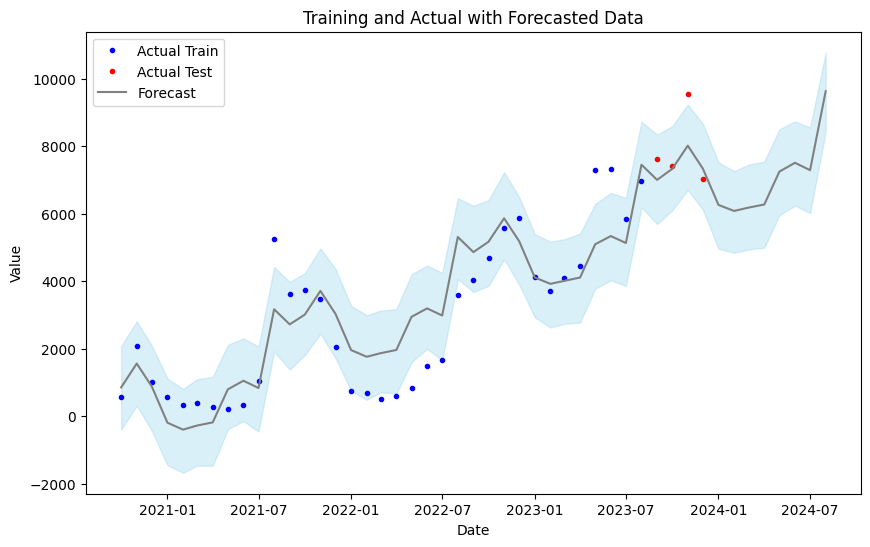

In [15]:
# show results
fig_1 = plt.figure(figsize=(10, 6))
plt.figure(figsize=(10, 6))
plt.plot(train["ds"], train["y"], '.', label='Actual Train', color = 'blue')
plt.plot(test["ds"], test["y"], '.', label='Actual Test', color = 'red')
plt.plot(forecast['ds'], forecast['yhat'], label='Forecast', color='grey')
plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='skyblue', alpha=0.3)
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Training and Actual with Forecasted Data')
plt.legend()
plt.show()

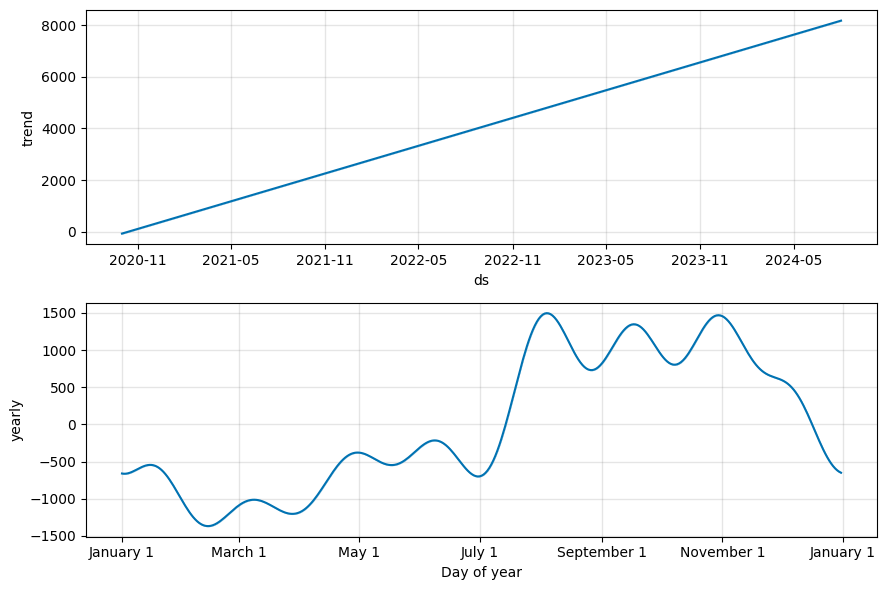

In [16]:
fig_2 = model.plot_components(forecast, plot_cap=20)